In [1]:
# ENSEMBLE LGBM with Catboost

## Library

In [2]:
! pip install pycld2

     |████████████████████████████████| 41.4 MB 4.4 MB/s            
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9917830 sha256=e5f5688bd3c5bcc1a3b476e919516805dfaa58d0e51c63cee48168d1e980429f
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2


In [3]:
# library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# sklearn
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# models
import lightgbm as lgb
from catboost import Pool
import catboost as cb
import xgboost as xgb

# others
from tqdm import tqdm_notebook as tqdm

from gensim.models import word2vec, KeyedVectors
import pycld2 as cld2

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

from tensorflow.keras.layers import Input,Dense,BatchNormalization,Dropout,Concatenate,Lambda,GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

## Config

In [4]:
# Config
SEED = 1010
SHUFFLE = True
N_SPLITS = 5
TRAIN = True
ENSEMBLE = True
# ENSEMBLE = False


EXP = '001'

# Model 
CATBOOST = True
XGBOOST = True


## LGBM 
LGBM_PARAMS = {
    'num_leaves': 300,
    'max_bin':450,
    'objective': 'binary',
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'metric':"binary_logloss",
    'verbose': -1

}
LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 50,
    'verbose_eval': 100,
}

## Catboost
CAT_PARAMS = {
    'early_stopping_rounds' : 50,
    'depth' : 6,  
    'learning_rate': 0.05,
    'iterations' : 5000, 
    'custom_loss' :['Logloss'], 
    'use_best_model':True, 
    'random_seed' :SEED
}

## xgboost
XGB_PARAMS = {
    'colsample_bytree': 0.8,                 
    'learning_rate': 0.003,
    'max_depth': 31,
    'subsample': 1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'min_child_weight':3,
    'gamma':0.25,
    'n_estimators':5000,
    'verbosity':0
}
XGB_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 50,
    'verbose_eval': 100,
}

# SEED
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(SEED)

## Function

### lgbm

In [5]:
def train_lgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):

    train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        #feature_name=feature_name
                        )

    if X_valid is not None:
        valid = lgb.Dataset(X_valid, y_valid,
                            categorical_feature=categorical_features,
                            #feature_name=feature_name
                            )

    if X_valid is not None:
        model = lgb.train(
            lgb_params,
            train,
            valid_sets=[train,valid],
            **fit_params
        )
    else:
        model = lgb.train(
            lgb_params,
            train,
            **fit_params
        )

    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(X_valid)
#         print(y_valid)
#         print(y_pred_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
        print('valid_loss: ', valid_loss)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
    else:
        y_pred_test = None

    #importance
    if calc_importances:
        importances = pd.DataFrame()
        #importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration, model

### catboost

In [6]:
def train_catboost(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, cat_params,loss_func, calc_importances=False):

    train = Pool(X_train, y_train)
    if X_valid is not None:
        valid = Pool(X_valid, y_valid)
    if X_valid is not None:
        model = cb.CatBoostClassifier(**cat_params)
        model.fit(train, eval_set=valid, verbose=False)
#         model = cb.CatBoost()
#         model.fit(train, eval_set=valid, verbose=False, **cat_params)
    else:
        model = cb.CatBoostClassifier(**cat_params)
        model.fit(train, verbose=False)

    # train score
    if X_valid is not None:
#         y_pred_valid = model.predict(X_valid)
        y_pred_valid = model.predict_proba(X_valid)[:,1]
#         print(y_valid)
#         print(y_pred_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
        print('valid_loss: ', valid_loss)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
#         y_pred_test = model.predict(X_test)
        y_pred_test = model.predict_proba(X_test)[:,1]
    else:
        y_pred_test = None

    #importance
    if calc_importances:
        importances = pd.DataFrame()
        #importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None
        
    print('get_best_iteration: ', model.get_best_iteration())

    return y_pred_valid, y_pred_test, valid_loss, importances, model.get_best_iteration(), model

### xgboost

In [7]:
def train_xgboost(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, xgb_params, fit_params, loss_func, calc_importances=False):

    train = xgb.DMatrix(X_train, y_train)
    X_test = xgb.DMatrix(X_test)
    
    if X_valid is not None:
        valid = xgb.DMatrix(X_valid, y_valid)
    if X_valid is not None:
        model = xgb.train(
            xgb_params,
            train,
            evals=[(train, 'train'), (valid, 'val')],
            **fit_params
        )
        
    else:
        model = xgb.train(
            xgb_params,
            train,
            **fit_params
        )

    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(valid)
#         y_pred_valid = model.predict_proba(X_valid)[:,1]
        valid_loss = loss_func(y_valid, y_pred_valid)
        print('valid_loss: ', valid_loss)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
#         y_pred_test = model.predict_proba(X_test)[:,1]
    else:
        y_pred_test = None

    #importance
    if calc_importances:
        importances = pd.DataFrame()
        #importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration, model

In [8]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "Score1", 
        "LTeamID" : "TeamIdB",
        "LScore": "Score2",
        'FGMW':'FGMA', 
        'FGAW':'FGAA', 
        'FGM3W':'FGM3A',
        'FGA3W':'FGA3A',
        'FTMW':'FTMA', 
        'FTAW':'FTAA', 
        'ORW':'ORA', 
        'DRW':'DRA',
        'AstW':'AstA',
        'TOW':'TOA',
        'StlW':'StlA',
        'BlkW':'BlkA',
        'PFW':'PFA',
        'FGRatioW':'FGRatioA',
        'FG3RatioW':'FG3RatioA',
        'FTRatioW':'FTRatioA',
        'eFGW':'eFGA',
        'TO%W':'TO%A',
        'FTRW':'FTRA',
        'POSSW':'POSSA',
        'PPPW':'PPPA',
        'TS%W':'TS%A',
        'EVW':'EVA',
        'TRW':'TRA',
        'OR%W':'OR%A',
        'ScoreW':'ScoreA',
        'ScoredW':'ScoredA',
        'ScoregapW':'ScoregapA',
        'NumWinsW': 'NumWinsA', 
        'NumLossesW':'NumLossesA', 
        'WinRatioW':'WinRatioA',
        'RatingW': 'RatingA',
        'FGML':'FGMB',
        'FGAL':'FGAB', 
        'FGM3L':'FGM3B',
        'FGA3L':'FGA3B',
        'FTML':'FTMB', 
        'FTAL':'FTAB', 
        'ORL':'ORB',
        'DRL':'DRB',
        'AstL':'AstB',
        'TOL':'TOB',
        'StlL':'StlB',
        'BlkL':'BlkB',
        'PFL':'PFB',
        'FGRatioL':'FGRatioB',
        'FG3RatioL':'FG3RatioB',
        'FTRatioL':'FTRatioB',
        'eFGL':'eFGB',
        'TO%L':'TO%B',
        'FTRL':'FTRB',
        'POSSL':'POSSB',
        'PPPL':'PPPB',
        'TS%L':'TS%B',
        'EVL':'EVB',
        'TRL':'TRB',
        'OR%L':'OR%B',
        'ScoreL':'ScoreB',
        'ScoredL':'ScoredB',
        'ScoregapL':'ScoregapB',
        'NumWinsL': 'NumWinsB',
        'NumLossesL':'NumLossesB', 
        'WinRatioL':'WinRatioB',
        'RatingL': 'RatingB',
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "Score2", 
        "LTeamID" : "TeamIdA",
        "LScore": "Score1",
        'FGMW':'FGMB', 
        'FGAW':'FGAB', 
        'FGM3W':'FGM3B',
        'FGA3W':'FGA3B',
        'FTMW':'FTMB', 
        'FTAW':'FTAB', 
        'ORW':'ORB', 
        'DRW':'DRB',
        'AstW':'AstB',
        'TOW':'TOB',
        'StlW':'StlB',
        'BlkW':'BlkB',
        'PFW':'PFB',
        'FGRatioW':'FGRatioB',
        'FG3RatioW':'FG3RatioB',
        'FTRatioW':'FTRatioB',
        'eFGW':'eFGB',
        'TO%W':'TO%B',
        'FTRW':'FTRB',
        'POSSW':'POSSB',
        'PPPW':'PPPB',
        'TS%W':'TS%B',
        'EVW':'EVB',
        'TRW':'TRB',
        'OR%W':'OR%B',
        'ScoreW':'ScoreB',
        'ScoredW':'ScoredB',
        'ScoregapW':'ScoregapB',
        'NumWinsW': 'NumWinsB', 
        'NumLossesW':'NumLossesB', 
        'WinRatioW':'WinRatioB',
        'RatingW': 'RatingB',
        'FGML':'FGMA',
        'FGAL':'FGAA', 
        'FGM3L':'FGM3A',
        'FGA3L':'FGA3A',
        'FTML':'FTMA', 
        'FTAL':'FTAA', 
        'ORL':'ORA',
        'DRL':'DRA',
        'AstL':'AstA',
        'TOL':'TOA',
        'StlL':'StlA',
        'BlkL':'BlkA',
        'PFL':'PFA',
        'FGRatioL':'FGRatioA',
        'FG3RatioL':'FG3RatioA',
        'FTRatioL':'FTRatioA',
        'eFGL':'eFGA',
        'TO%L':'TO%A',
        'FTRL':'FTRA',
        'POSSL':'POSSA',
        'PPPL':'PPPA',
        'TS%L':'TS%A',
        'EVL':'EVA',
        'TRL':'TRA',
        'OR%L':'OR%A',
        'ScoreL':'ScoreA',
        'ScoredL':'ScoredA',
        'ScoregapL':'ScoregapA',
        'NumWinsL': 'NumWinsA',
        'NumLossesL':'NumLossesA', 
        'WinRatioL':'WinRatioA',
        'RatingL': 'RatingA',
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [9]:
# Loss
def calc_loss(y_true, y_pred):
    return  log_loss(y_true, y_pred)

# Reading data

In [10]:
flist = os.listdir('../input/mens-march-mania-2022/MDataFiles_Stage1/')
print(len(flist))
flist

20


['Conferences.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MRegularSeasonDetailedResults.csv',
 'MNCAATourneyCompactResults.csv',
 'MGameCities.csv',
 'MSeasons.csv',
 'MSecondaryTourneyTeams.csv',
 'Cities.csv',
 'MTeamSpellings.csv',
 'MRegularSeasonCompactResults.csv',
 'MMasseyOrdinals.csv',
 'MSecondaryTourneyCompactResults.csv',
 'MNCAATourneySlots.csv',
 'MNCAATourneySeeds.csv',
 'MTeamCoaches.csv',
 'MConferenceTourneyGames.csv',
 'MNCAATourneyDetailedResults.csv',
 'MSampleSubmissionStage1.csv',
 'MTeamConferences.csv',
 'MTeams.csv']

In [11]:
# datasets_path = './ncaam-march-mania-2021/MDataFiles_Stage2/'
datasets_path = '../input/mens-march-mania-2022/MDataFiles_Stage1/'
SAVE_TEST_SUB_PATH = f"exp{EXP}_submission.csv"
# SUB_PATH = datasets_path + 'MSampleSubmissionStage2.csv'
SUB_PATH = datasets_path + 'MSampleSubmissionStage1.csv'

In [12]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RankingDayNum':'DayNum'})
ordinals.head()

,Season,DayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [13]:
seeds = pd.read_csv(datasets_path + 'MNCAATourneySeeds.csv')
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [14]:
regular_result = pd.read_csv(datasets_path + 'MRegularSeasonDetailedResults.csv')
regular_result

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,3,20,20,23,14,18,8,6,7,2,21,28,48,5,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,2,20,16,28,12,27,9,19,10,5,19,20,49,8,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,13,32,9,13,11,22,11,15,11,1,13,18,53,5,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,2,12,5,9,10,20,16,5,10,2,17,22,52,6,17,18,22,11,25,14,14,3,9,11


## Preprocessing, FE

In [15]:
ordinals = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()
ordinals = ordinals.groupby(['Season','TeamID'])['OrdinalRank'].apply(list).apply(np.mean).reset_index()
ordinals['Rating']= 100-4*np.log(ordinals['OrdinalRank']+1)-ordinals['OrdinalRank']/22

ordinals

,Season,TeamID,OrdinalRank,Rating
0,2003,1102,154.058824,72.822108
1,2003,1103,168.705882,71.795283
2,2003,1104,36.638889,83.822445
3,2003,1105,308.735294,63.023705
4,2003,1106,260.911765,65.868344
...,...,...,...,...
6897,2022,1468,195.214286,70.009794
6898,2022,1469,276.607143,64.922120
6899,2022,1470,208.107143,69.169197
6900,2022,1471,272.892857,65.144831


In [16]:
num_win = regular_result.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
num_win

,Season,TeamID,NumWins
0,2003,1102,12
1,2003,1103,13
2,2003,1104,17
3,2003,1105,7
4,2003,1106,13
...,...,...,...
6878,2022,1468,9
6879,2022,1469,7
6880,2022,1470,8
6881,2022,1471,8


In [17]:
num_loss = regular_result.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})
num_loss

,Season,TeamID,NumLosses
0,2003,1102,16
1,2003,1103,14
2,2003,1104,11
3,2003,1105,19
4,2003,1106,15
...,...,...,...
6884,2022,1468,11
6885,2022,1469,12
6886,2022,1470,13
6887,2022,1471,12


In [18]:
wl = pd.merge(num_win, num_loss, how='left', on=['Season', 'TeamID']).reset_index(drop=True)
wl

,Season,TeamID,NumWins,NumLosses
0,2003,1102,12,16.0
1,2003,1103,13,14.0
2,2003,1104,17,11.0
3,2003,1105,7,19.0
4,2003,1106,13,15.0
...,...,...,...,...
6878,2022,1468,9,11.0
6879,2022,1469,7,12.0
6880,2022,1470,8,13.0
6881,2022,1471,8,12.0


In [19]:
wteam_stats = regular_result.groupby(['Season', 'WTeamID']).mean().reset_index()
wteam_stats.drop(['DayNum','LTeamID', 'NumOT','LFGM', 'LFGA', 'LFGM3', 'LFGA3',
'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
], axis=1, inplace=True)
wteam_stats = wteam_stats.rename(columns={"WTeamID": "TeamID", 'WScore':'Score','LScore':'Scored', 'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3','WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA', 'WOR':'OR', 'WDR':'DR','WAst':'Ast','WTO':'TO','WStl':'Stl','WBlk':'Blk','WPF':'PF'})
wteam_stats

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,68.750000,53.166667,22.583333,40.000000,10.000000,21.583333,13.583333,20.750000,3.833333,19.333333,16.916667,11.083333,7.333333,2.833333,16.083333
1,2003,1103,87.769231,78.384615,30.000000,55.384615,5.461538,14.384615,22.307692,30.923077,9.384615,21.461538,17.692308,12.538462,7.307692,1.846154,20.461538
2,2003,1104,74.705882,61.529412,25.823529,58.352941,7.058824,20.823529,16.000000,22.529412,13.529412,26.411765,14.000000,13.058824,7.235294,4.176471,16.470588
3,2003,1105,79.428571,66.428571,25.571429,61.857143,9.142857,22.428571,19.142857,25.714286,14.571429,25.857143,15.857143,18.000000,11.285714,2.000000,19.428571
4,2003,1106,68.307692,57.923077,24.769231,53.846154,5.846154,15.923077,12.923077,20.769231,12.769231,28.000000,13.000000,17.692308,9.384615,3.769231,18.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6878,2022,1468,74.555556,63.888889,28.222222,54.666667,8.333333,21.777778,9.777778,13.000000,5.333333,21.666667,16.888889,8.000000,5.777778,2.333333,14.333333
6879,2022,1469,79.571429,68.142857,28.142857,60.714286,8.285714,21.857143,15.000000,21.285714,9.142857,26.857143,17.857143,11.857143,5.285714,2.142857,20.857143
6880,2022,1470,70.625000,59.500000,25.000000,53.500000,6.875000,18.000000,13.750000,19.000000,7.500000,20.625000,13.875000,9.250000,6.875000,2.000000,17.125000
6881,2022,1471,79.000000,68.875000,24.875000,51.500000,9.625000,23.125000,19.625000,24.625000,4.500000,25.750000,13.375000,13.375000,5.500000,1.875000,15.625000


In [20]:
lteam_stats = regular_result.groupby(['Season', 'LTeamID']).mean().reset_index()
lteam_stats.drop(['DayNum', 'WTeamID', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3',
'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
], axis=1, inplace=True)
lteam_stats = lteam_stats.rename(columns={"LTeamID": "TeamID", 'LScore':'Score','WScore':'Scored', 'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3','LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA', 'LOR':'OR', 'LDR':'DR','LAst':'Ast','LTO':'TO','LStl':'Stl','LBlk':'Blk','LPF':'PF'})
lteam_stats

,Season,TeamID,Scored,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,59.875000,48.625000,16.562500,39.625000,6.187500,20.250000,9.312500,14.375000,4.437500,14.937500,10.062500,11.687500,4.937500,1.000000,20.750000
1,2003,1103,77.928571,70.428571,24.500000,56.285714,5.428571,17.642857,16.000000,21.142857,10.142857,18.500000,12.928571,12.714286,7.214286,2.785714,19.285714
2,2003,1104,70.363636,60.909091,21.272727,55.363636,5.272727,18.363636,13.090909,18.454545,13.636364,20.090909,9.181818,13.636364,5.636364,3.181818,20.454545
3,2003,1105,80.421053,68.947368,23.947368,61.526316,7.000000,20.157895,14.052632,20.421053,13.105263,22.105263,14.052632,18.894737,8.578947,2.105263,20.526316
4,2003,1106,68.800000,59.533333,22.266667,56.533333,6.333333,19.133333,8.666667,12.733333,11.866667,20.266667,10.533333,16.466667,7.466667,2.600000,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,2022,1468,76.636364,60.090909,22.454545,55.000000,6.181818,22.363636,9.000000,12.181818,6.363636,19.818182,10.363636,11.181818,4.090909,1.000000,17.454545
6885,2022,1469,83.000000,63.666667,21.750000,57.166667,5.416667,21.500000,14.750000,21.583333,8.500000,21.750000,12.750000,16.916667,6.750000,2.416667,19.250000
6886,2022,1470,70.769231,59.000000,21.153846,55.769231,4.076923,15.846154,12.615385,16.692308,7.307692,18.153846,7.846154,10.769231,9.000000,2.230769,19.153846
6887,2022,1471,72.583333,59.166667,21.250000,53.000000,7.083333,24.083333,9.583333,14.583333,5.000000,19.416667,11.000000,13.166667,5.500000,1.416667,14.666667


In [21]:
regular_season_feature = pd.concat([wteam_stats, lteam_stats], 0).reset_index(drop=True)
regular_season_feature = regular_season_feature.groupby(['Season', 'TeamID']).mean().reset_index()

# Score-gab
regular_season_feature['Scoregap'] = regular_season_feature['Score'] -regular_season_feature['Scored']
# FGM/FGA
regular_season_feature['FGRatio'] = regular_season_feature['FGM']/regular_season_feature['FGA']
# FGM3/FGA3
regular_season_feature['FG3Ratio'] = regular_season_feature['FGM3']/regular_season_feature['FGA3']
# FTM/FTA
regular_season_feature['FTRatio'] = regular_season_feature['FTM']/regular_season_feature['FTA']
# EV(expect value)
regular_season_feature['EV'] = regular_season_feature['FGM']*regular_season_feature['FGRatio']+regular_season_feature['FGM3']*regular_season_feature['FG3Ratio']+regular_season_feature['FTM']*regular_season_feature['FTRatio']
# TR
regular_season_feature['TR'] = regular_season_feature['OR']+regular_season_feature['DR']
# TS%
regular_season_feature['TS%'] = regular_season_feature['Score']/(2*(regular_season_feature['FGA'] +0.44*regular_season_feature['FTA']))

# Four-Factor
regular_season_feature['eFG'] = (regular_season_feature['FGM'] +0.5*regular_season_feature['FGM3'])/regular_season_feature['FGA']

regular_season_feature['OR%'] = regular_season_feature['OR']/regular_season_feature['FGA']

regular_season_feature['TO%'] = regular_season_feature['TO']/(regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] +regular_season_feature['TO'])

regular_season_feature['FTR'] = regular_season_feature['FTA']/regular_season_feature['FGA']

# PPP/POSS
regular_season_feature['POSS'] = regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] +regular_season_feature['TO']

regular_season_feature['PPP'] = regular_season_feature['Score']/regular_season_feature['POSS']

# Win-Losses
regular_season_feature = regular_season_feature.merge(wl, on=['Season', 'TeamID'],how='left').reset_index(drop=True)
regular_season_feature['WinRatio'] = regular_season_feature['NumWins']/(regular_season_feature['NumWins']+regular_season_feature['NumLosses'])

#regular_season_feature.drop(['Score'], axis=1, inplace=True)
regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Scoregap,FGRatio,FG3Ratio,FTRatio,EV,TR,TS%,eFG,OR%,TO%,FTR,POSS,PPP,NumWins,NumLosses,WinRatio
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667,2.166667,0.491627,0.386952,0.651839,20.216672,21.270833,0.617243,0.593276,0.103872,0.193217,0.441130,58.925417,0.995962,12.0,16.0,0.428571
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,9.763736,19.980769,15.310440,12.626374,7.260989,2.315934,19.873626,0.942308,0.488044,0.340024,0.735753,29.243149,29.744505,0.587749,0.536804,0.174867,0.157995,0.466247,79.916044,0.989775,13.0,14.0,0.481481
2,2003,1104,67.807487,65.946524,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,13.582888,23.251337,11.590909,13.347594,6.435829,3.679144,18.462567,1.860963,0.414155,0.314683,0.709812,22.017375,36.834225,0.514670,0.468375,0.238890,0.168483,0.360404,79.222353,0.855914,17.0,11.0,0.607143
3,2003,1105,74.187970,73.424812,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,13.838346,23.981203,14.954887,18.447368,9.932331,2.052632,19.977444,0.763158,0.401341,0.379061,0.719524,24.938992,37.819549,0.516331,0.466758,0.224314,0.204315,0.373918,90.288872,0.821673,7.0,19.0,0.269231
4,2003,1106,63.920513,63.361538,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,12.317949,24.133333,11.766667,17.079487,8.425641,3.184615,18.192308,0.558974,0.426129,0.347425,0.644421,19.093849,36.451282,0.510871,0.481300,0.223193,0.214459,0.303522,79.639795,0.802620,13.0,15.0,0.464286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1468,67.323232,70.262626,25.338384,54.833333,7.257576,22.070707,9.388889,12.590909,5.848485,20.742424,13.626263,9.590909,4.934343,1.666667,15.893939,-2.939394,0.462098,0.328833,0.745688,21.096532,26.590909,0.557558,0.528277,0.106659,0.137083,0.229621,69.964242,0.962252,9.0,11.0,0.450000
6888,2022,1469,71.619048,75.571429,24.946429,58.940476,6.851190,21.678571,14.875000,21.434524,8.821429,24.303571,15.303571,14.386905,6.017857,2.279762,20.053571,-3.952381,0.423248,0.316035,0.693974,23.046600,33.125000,0.523748,0.481367,0.149667,0.173842,0.363664,82.758571,0.865397,7.0,12.0,0.368421
6889,2022,1470,64.812500,65.134615,23.076923,54.634615,5.475962,16.923077,13.182692,17.846154,7.403846,19.389423,10.860577,10.009615,7.937500,2.115385,18.139423,-0.322115,0.422386,0.323580,0.738685,21.257151,26.793269,0.518609,0.472501,0.135516,0.138070,0.326646,72.496538,0.894008,8.0,13.0,0.380952
6890,2022,1471,69.083333,70.729167,23.062500,52.250000,8.354167,23.604167,14.604167,19.604167,4.750000,22.583333,12.187500,13.270833,5.500000,1.645833,15.145833,-1.645833,0.441388,0.353928,0.744952,24.015677,27.333333,0.567412,0.521332,0.090909,0.178981,0.375199,74.146667,0.931712,8.0,12.0,0.400000


In [22]:
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')
tourney_results = tourney_results[tourney_results['Season'] >= 2003].reset_index(drop=True)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2003,134,1421,92,1411,84,N,1
1,2003,136,1112,80,1436,51,N,0
2,2003,136,1113,84,1272,71,N,0
3,2003,136,1141,79,1166,73,N,0
4,2003,136,1143,76,1301,74,N,1
...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0
1177,2021,148,1417,51,1276,49,N,0
1178,2021,152,1124,78,1222,59,N,0
1179,2021,152,1211,93,1417,90,N,1


In [23]:
tourney_results = tourney_results.merge(regular_season_feature,
left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsW', 'NumLosses':'NumLossesW', 'WinRatio': 'WinRatioW',
    'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW','OR':'ORW',
    'DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
    'FGRatio':'FGRatioW','FG3Ratio':'FG3RatioW','FTRatio':'FTRatioW','eFG':'eFGW','TO%':'TO%W','FTR':'FTRW',
    'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W','Score':'ScoreW',
    'Scored':'ScoredW','Scoregap':'ScoregapW'
}).drop(columns='TeamID', axis=1)

tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingW'}).drop(columns='TeamID', axis=1)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FGRatioW,FG3RatioW,FTRatioW,EVW,TRW,TS%W,eFGW,OR%W,TO%W,FTRW,POSSW,PPPW,NumWinsW,NumLossesW,WinRatioW,RatingW
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,-5.963942,0.433219,0.363905,0.763391,25.396067,35.752404,0.543616,0.490556,0.215828,0.195465,0.372333,82.298750,0.874715,13.0,16.0,0.448276,66.998625
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,6.473333,0.423003,0.297290,0.684928,25.621816,42.166667,0.513412,0.472867,0.238247,0.156402,0.347843,94.201600,0.866227,25.0,3.0,0.892857,94.745251
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,3.421717,0.465366,0.316786,0.666897,25.085451,36.292929,0.543732,0.501567,0.237605,0.170127,0.447574,82.499293,0.902456,18.0,11.0,0.620690,83.956178
3,2003,136,1141,79,1166,73,N,0,73.673913,74.753623,24.728261,52.742754,6.275362,18.326087,17.942029,24.061594,11.108696,22.311594,14.036232,18.398551,6.757246,3.692029,22.333333,-1.079710,0.468847,0.342428,0.745671,27.121468,33.420290,0.581668,0.528337,0.210620,0.225118,0.456207,81.728406,0.901448,23.0,6.0,0.793103,82.069442
4,2003,136,1143,76,1301,74,N,1,73.172619,73.044643,27.160714,60.241071,6.711310,18.068452,12.139881,18.080357,11.863095,23.139881,15.458333,13.964286,6.303571,2.741071,17.806548,0.127976,0.450867,0.371438,0.671440,22.889912,35.002976,0.536484,0.506571,0.196927,0.169963,0.300133,82.160714,0.890603,21.0,8.0,0.724138,83.911438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,92.115385,69.115385,34.153846,62.000000,7.307692,20.038462,16.500000,22.730769,8.230769,27.269231,18.307692,11.923077,8.307692,2.846154,3.576923,23.000000,0.550868,0.364683,0.725888,33.456428,35.500000,0.639677,0.609801,0.132754,0.142069,0.366625,83.924615,1.097597,26.0,NaN,NaN,97.110795
1177,2021,148,1417,51,1276,49,N,0,71.339869,69.872549,25.875817,56.748366,6.369281,17.983660,13.218954,18.339869,8.692810,23.232026,13.104575,11.016340,4.928105,2.630719,5.179739,1.467320,0.455975,0.354170,0.720777,23.582445,31.924837,0.550310,0.512093,0.153182,0.145269,0.323179,75.834248,0.940734,17.0,9.0,0.653846,82.778065
1178,2021,152,1124,78,1222,59,N,0,76.022727,71.227273,28.772727,66.431818,8.363636,25.750000,10.113636,15.886364,12.772727,20.159091,14.068182,10.045455,7.159091,3.181818,12.636364,4.795455,0.433117,0.324801,0.636624,21.617050,32.931818,0.517712,0.496066,0.192268,0.120352,0.239138,83.467273,0.910809,22.0,2.0,0.916667,94.281929
1179,2021,152,1211,93,1417,90,N,1,92.115385,69.115385,34.153846,62.000000,7.307692,20.038462,16.500000,22.730769,8.230769,27.269231,18.307692,11.923077,8.307692,2.846154,3.576923,23.000000,0.550868,0.364683,0.725888,33.456428,35.500000,0.639677,0.609801,0.132754,0.142069,0.366625,83.924615,1.097597,26.0,NaN,NaN,97.110795


In [24]:
tourney_results = tourney_results.merge(regular_season_feature,
left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsL', 'NumLosses':'NumLossesL', 'WinRatio': 'WinRatioL',
    'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
    'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
    'FGRatio':'FGRatioL','FG3Ratio':'FG3RatioL','FTRatio':'FTRatioL','eFG':'eFGL','TO%':'TO%L','FTR':'FTRL',
    'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
    'Scored':'ScoredL','Scoregap':'ScoregapL'
}).drop(columns='TeamID', axis=1)

tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingL'}).drop(columns='TeamID', axis=1)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FGRatioW,FG3RatioW,FTRatioW,EVW,TRW,TS%W,eFGW,OR%W,TO%W,FTRW,POSSW,PPPW,NumWinsW,NumLossesW,WinRatioW,RatingW,ScoreL,ScoredL,FGML,FGAL,FGM3L,FGA3L,FTML,FTAL,ORL,DRL,AstL,TOL,StlL,BlkL,PFL,ScoregapL,FGRatioL,FG3RatioL,FTRatioL,EVL,TRL,TS%L,eFGL,OR%L,TO%L,FTRL,POSSL,PPPL,NumWinsL,NumLossesL,WinRatioL,RatingL
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,-5.963942,0.433219,0.363905,0.763391,25.396067,35.752404,0.543616,0.490556,0.215828,0.195465,0.372333,82.298750,0.874715,13.0,16.0,0.448276,66.998625,71.666667,71.472222,24.513889,55.611111,5.916667,18.750000,16.722222,27.194444,13.458333,24.111111,13.958333,14.958333,6.569444,2.277778,18.208333,0.194444,0.440809,0.315556,0.614913,22.955699,37.569444,0.530262,0.494006,0.242008,0.181236,0.489011,82.535000,0.868318,18.0,12.0,0.600000,67.244877
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,6.473333,0.423003,0.297290,0.684928,25.621816,42.166667,0.513412,0.472867,0.238247,0.156402,0.347843,94.201600,0.866227,25.0,3.0,0.892857,94.745251,65.994737,64.668421,24.228947,56.155263,5.257895,15.960526,12.278947,18.994737,12.902632,25.102632,13.542105,14.336842,6.776316,2.902632,16.181579,1.326316,0.431464,0.329431,0.646439,20.123617,38.005263,0.511484,0.478279,0.229767,0.181825,0.338254,78.849789,0.836968,19.0,10.0,0.655172,72.885042
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,3.421717,0.465366,0.316786,0.666897,25.085451,36.292929,0.543732,0.501567,0.237605,0.170127,0.447574,82.499293,0.902456,18.0,11.0,0.620690,83.956178,74.079710,71.065217,25.742754,60.800725,6.692029,20.228261,15.902174,24.289855,14.474638,24.992754,15.221014,13.376812,7.115942,5.105072,20.079710,3.014493,0.423396,0.330826,0.654684,23.524157,39.467391,0.518125,0.478428,0.238067,0.157624,0.399499,84.865072,0.872912,23.0,6.0,0.793103,86.125540
3,2003,136,1141,79,1166,73,N,0,73.673913,74.753623,24.728261,52.742754,6.275362,18.326087,17.942029,24.061594,11.108696,22.311594,14.036232,18.398551,6.757246,3.692029,22.333333,-1.079710,0.468847,0.342428,0.745671,27.121468,33.420290,0.581668,0.528337,0.210620,0.225118,0.456207,81.728406,0.901448,23.0,6.0,0.793103,82.069442,74.719828,68.823276,27.103448,57.474138,7.659483,20.491379,12.853448,18.077586,11.362069,21.379310,14.418103,13.637931,7.362069,3.612069,17.909483,5.896552,0.471576,0.373790,0.711016,24.783393,32.741379,0.571006,0.538211,0.197690,0.172487,0.314534,79.066207,0.945029,29.0,4.0,0.878788,86.828207
4,2003,136,1143,76,1301,74,N,1,73.172619,73.044643,27.160714,60.241071,6.711310,18.068452,12.139881,18.080357,11.863095,23.139881,15.458333,13.964286,6.303571,2.741071,17.806548,0.127976,0.450867,0.371438,0.671440,22.889912,35.002976,0.536484,0.506571,0.196927,0.169963,0.300133,82.160714,0.890603,21.0,8.0,0.724138,83.911438,71.027778,69.291667,24.000000,53.569444,7.722222,22.500000,15.305556,19.902778,9.861111,21.666667,14.166667,14.291667,7.583333,2.944444,19.097222,1.736111,0.448017,0.343210,0.769016,25.172959,31.527778,0.569802,0.520093,0.184081,0.186531,0.371532,76.618333,0.927034,18.0,12.0,0.600000,81.985822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,92.115385,69.115385,34.153846,62.000000,7.307692,20.038462,16.500000,22.730769,8.230769,27.269231,18.307692,11.

In [25]:
tourney_results = add_loosing_matches(tourney_results)
tourney_results['ScoreDiff'] = tourney_results['Score1'] - tourney_results['Score2']
tourney_results['WinA'] = (tourney_results['ScoreDiff'] > 0).astype(int)
tourney_results

,Season,DayNum,TeamIdA,Score1,TeamIdB,Score2,WLoc,NumOT,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FGRatioA,FG3RatioA,FTRatioA,EVA,TRA,TS%A,eFGA,OR%A,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,RatingA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FGRatioB,FG3RatioB,FTRatioB,EVB,TRB,TS%B,eFGB,OR%B,TO%B,FTRB,POSSB,PPPB,NumWinsB,NumLossesB,WinRatioB,RatingB,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,24.646635,56.891827,6.524038,17.927885,16.170673,21.182692,12.278846,23.473558,13.341346,16.086538,7.213942,3.050481,19.000000,-5.963942,0.433219,0.363905,0.763391,25.396067,35.752404,0.543616,0.490556,0.215828,0.195465,0.372333,82.298750,0.874715,13.0,16.0,0.448276,66.998625,71.666667,71.472222,24.513889,55.611111,5.916667,18.750000,16.722222,27.194444,13.458333,24.111111,13.958333,14.958333,6.569444,2.277778,18.208333,0.194444,0.440809,0.315556,0.614913,22.955699,37.569444,0.530262,0.494006,0.242008,0.181236,0.489011,82.535000,0.868318,18.0,12.0,0.600000,67.244877,8,1
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,29.153333,68.920000,6.873333,23.120000,16.420000,23.973333,16.420000,25.746667,15.600000,14.733333,8.553333,4.120000,18.740000,6.473333,0.423003,0.297290,0.684928,25.621816,42.166667,0.513412,0.472867,0.238247,0.156402,0.347843,94.201600,0.866227,25.0,3.0,0.892857,94.745251,65.994737,64.668421,24.228947,56.155263,5.257895,15.960526,12.278947,18.994737,12.902632,25.102632,13.542105,14.336842,6.776316,2.902632,16.181579,1.326316,0.431464,0.329431,0.646439,20.123617,38.005263,0.511484,0.478279,0.229767,0.181825,0.338254,78.849789,0.836968,19.0,10.0,0.655172,72.885042,29,1
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,26.618687,57.199495,4.141414,13.073232,17.073232,25.601010,13.590909,22.702020,15.108586,14.035354,5.042929,3.893939,19.722222,3.421717,0.465366,0.316786,0.666897,25.085451,36.292929,0.543732,0.501567,0.237605,0.170127,0.447574,82.499293,0.902456,18.0,11.0,0.620690,83.956178,74.079710,71.065217,25.742754,60.800725,6.692029,20.228261,15.902174,24.289855,14.474638,24.992754,15.221014,13.376812,7.115942,5.105072,20.079710,3.014493,0.423396,0.330826,0.654684,23.524157,39.467391,0.518125,0.478428,0.238067,0.157624,0.399499,84.865072,0.872912,23.0,6.0,0.793103,86.125540,13,1
3,2003,136,1141,79,1166,73,N,0,73.673913,74.753623,24.728261,52.742754,6.275362,18.326087,17.942029,24.061594,11.108696,22.311594,14.036232,18.398551,6.757246,3.692029,22.333333,-1.079710,0.468847,0.342428,0.745671,27.121468,33.420290,0.581668,0.528337,0.210620,0.225118,0.456207,81.728406,0.901448,23.0,6.0,0.793103,82.069442,74.719828,68.823276,27.103448,57.474138,7.659483,20.491379,12.853448,18.077586,11.362069,21.379310,14.418103,13.637931,7.362069,3.612069,17.909483,5.896552,0.471576,0.373790,0.711016,24.783393,32.741379,0.571006,0.538211,0.197690,0.172487,0.314534,79.066207,0.945029,29.0,4.0,0.878788,86.828207,6,1
4,2003,136,1143,76,1301,74,N,1,73.172619,73.044643,27.160714,60.241071,6.711310,18.068452,12.139881,18.080357,11.863095,23.139881,15.458333,13.964286,6.303571,2.741071,17.806548,0.127976,0.450867,0.371438,0.671440,22.889912,35.002976,0.536484,0.506571,0.196927,0.169963,0.300133,82.160714,0.890603,21.0,8.0,0.724138,83.911438,71.027778,69.291667,24.000000,53.569444,7.722222,22.500000,15.305556,19.902778,9.861111,21.666667,14.166667,14.291667,7.583333,2.944444,19.097222,1.736111,0.448017,0.343210,0.769016,25.172959,31.527778,0.569802,0.520093,0.184081,0.186531,0.371532,76.618333,0.927034,18.0,12.0,0.600000,81.985822,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1425,66,1211,85,N,0,70.750000,67.016234,25.750000,57.626623,6.107143,18.237013,13.1428

## Test

In [26]:
SUB_PATH

'../input/mens-march-mania-2022/MDataFiles_Stage1/MSampleSubmissionStage1.csv'

In [27]:
# test = pd.read_csv(datasets_path + "MSampleSubmissionStage2.csv")
test = pd.read_csv(SUB_PATH)
test.head()

,ID,Pred
0,2016_1112_1114,0.5
1,2016_1112_1122,0.5
2,2016_1112_1124,0.5
3,2016_1112_1138,0.5
4,2016_1112_1139,0.5


In [28]:
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2016_1112_1114,0.5,2016,1112,1114
1,2016_1112_1122,0.5,2016,1112,1122
2,2016_1112_1124,0.5,2016,1112,1124
3,2016_1112_1138,0.5,2016,1112,1138
4,2016_1112_1139,0.5,2016,1112,1139


In [29]:
test = test.merge(regular_season_feature,
left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsA', 'NumLosses':'NumLossesA', 'WinRatio': 'WinRatioA',
    'FGM':'FGMA', 'FGA':'FGAA', 'FGM3':'FGM3A','FGA3':'FGA3A', 'FTM':'FTMA', 'FTA':'FTAA', 'OR':'ORA', 
    'DR':'DRA','Ast':'AstA','TO':'TOA','Stl':'StlA','Blk':'BlkA','PF':'PFA',
    'FGRatio':'FGRatioA','FG3Ratio':'FG3RatioA','FTRatio':'FTRatioA','eFG':'eFGA','TO%':'TO%A','FTR':'FTRA',
    'POSS':'POSSA','PPP':'PPPA','TS%':'TS%A','EV':'EVA','TR':'TRA','OR%':'OR%A','Score':'ScoreA',
    'Scored':'ScoredA','Scoregap':'ScoregapA'
}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingA'}).drop(columns='TeamID', axis=1)
test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FGRatioA,FG3RatioA,FTRatioA,EVA,TRA,TS%A,eFGA,OR%A,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,RatingA
0,2016_1112_1114,0.5,2016,1112,1114,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100
1,2016_1112_1122,0.5,2016,1112,1122,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100
2,2016_1112_1124,0.5,2016,1112,1124,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100
3,2016_1112_1138,0.5,2016,1112,1138,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100
4,2016_1112_1139,0.5,2016,1112,1139,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,77.305556,74.638889,26.388889,62.250000,7.444444,21.111111,17.083333,23.833333,11.972222,22.611111,13.750000,11.777778,7.361111,2.888889,4.555556,2.666667,0.423918,0.352632,0.716783,26.056915,34.583333,0.531407,0.483713,0.192325,0.139358,0.382865,84.514444,0.914702,18.0,9.0,0.666667,86.851044
11386,2021_1452_1458,0.5,2021,1452,1458,77.305556,74.638889,26.388889,62.250000,7.444444,21.111111,17.083333,23.833333,11.972222,22.611111,13.750000,11.777778,7.361111,2.888889,4.555556,2.666667,0.423918,0.352632,0.716783,26.056915,34.583333,0.531407,0.483713,0.192325,0.139358,0.382865,84.514444,0.914702,18.0,9.0,0.666667,86.851044
11387,2021_1455_1457,0.5,2021,1455,1457,68.071429,68.921429,22.964286,59.707143,7.671429,24.307143,14.471429,21.200000,8.871429,23.450000,11.735714,10.714286,5.821429,3.542857,3.328571,-0.850000,0.384615,0.315604,0.682615,21.131958,32.321429,0.493020,0.448858,0.148582,0.134349,0.355066,79.749429,0.853566,14.0,5.0,0.736842,81.154613
11388,2021_1455_1458,0.5,2021,1455,1458,68.071429,68.921429,22.964286,59.707143,7.671429,24.307143,14.471429,21.200000,8.871429,23.450000,11.735714,10.714286,5.821429,3.542857,3.328571,-0.850000,0.384615,0.315604,0.682615,21.131958,32.321429,0.493020,0.448858,0.148582,0.134349,0.355066,79.749429,0.853566,14.0,5.0,0.736842,81.154613


In [30]:
test = test.merge(regular_season_feature,
left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsB', 'NumLosses':'NumLossesB', 'WinRatio': 'WinRatioB',
    'FGM':'FGMB', 'FGA':'FGAB', 'FGM3':'FGM3B','FGA3':'FGA3B', 'FTM':'FTMB', 'FTA':'FTAB', 'OR':'ORB', 
    'DR':'DRB','Ast':'AstB','TO':'TOB','Stl':'StlB','Blk':'BlkB','PF':'PFB',
    'FGRatio':'FGRatioB','FG3Ratio':'FG3RatioB','FTRatio':'FTRatioB','eFG':'eFGB','TO%':'TO%B','FTR':'FTRB',
    'POSS':'POSSB','PPP':'PPPB','TS%':'TS%B','EV':'EVB','TR':'TRB','OR%':'OR%B','Score':'ScoreB',
    'Scored':'ScoredB','Scoregap':'ScoregapB'
}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={'Rating':'RatingB'}).drop(columns='TeamID', axis=1)
test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FGRatioA,FG3RatioA,FTRatioA,EVA,TRA,TS%A,eFGA,OR%A,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,RatingA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FGRatioB,FG3RatioB,FTRatioB,EVB,TRB,TS%B,eFGB,OR%B,TO%B,FTRB,POSSB,PPPB,NumWinsB,NumLossesB,WinRatioB,RatingB
0,2016_1112_1114,0.5,2016,1112,1114,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100,69.041667,66.000000,23.847222,54.870370,6.990741,19.958333,14.356481,19.097222,8.194444,23.472222,10.601852,10.768519,6.592593,2.824074,20.810185,3.041667,0.434610,0.350267,0.751758,23.605464,31.666667,0.545584,0.498313,0.149342,0.145439,0.348043,74.041667,0.932470,27.0,4.0,0.870968,81.268118
1,2016_1112_1122,0.5,2016,1112,1122,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100,74.981618,77.042279,25.650735,55.634191,6.235294,17.801471,17.444853,25.985294,11.077206,24.825368,12.946691,14.529412,6.893382,2.764706,17.606618,-2.060662,0.461061,0.350268,0.671336,25.721922,35.902574,0.558999,0.517099,0.199108,0.178063,0.467074,81.597132,0.918925,16.0,17.0,0.484848,68.986766
2,2016_1112_1124,0.5,2016,1112,1124,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100,73.792208,71.380952,25.948052,57.904762,6.229437,17.034632,15.666667,21.982684,13.731602,22.538961,15.880952,13.095238,7.612554,3.781385,19.829004,2.411255,0.448116,0.365693,0.712682,25.071150,36.270563,0.545985,0.501906,0.237141,0.162326,0.379635,80.672381,0.914715,21.0,11.0,0.656250,85.934626
3,2016_1112_1138,0.5,2016,1112,1138,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100,75.492481,76.699248,25.522556,59.385338,7.156015,21.748120,17.291353,24.513158,12.078947,26.640977,12.201128,14.001880,6.575188,3.486842,21.453008,-1.206767,0.429779,0.329041,0.705391,25.520832,38.719925,0.537917,0.490029,0.203399,0.166346,0.412781,84.173008,0.896873,19.0,14.0,0.575758,75.102479
4,2016_1112_1139,0.5,2016,1112,1139,80.077500,73.420000,28.465000,59.647500,6.340000,16.850000,16.807500,22.995000,12.355000,27.720000,13.872500,13.305000,4.642500,4.987500,18.437500,6.657500,0.477220,0.376261,0.730920,28.254506,40.075000,0.573906,0.530366,0.207134,0.160166,0.385515,83.070300,0.963973,25.0,8.0,0.757576,87.785100,76.683333,72.350000,26.952381,60.514286,6.914286,18.288095,15.864286,21.833333,11.807143,23.847619,13.450000,10.140476,6.283333,3.157143,19.823810,4.333333,0.445389,0.378076,0.726609,26.145536,35.654762,0.546793,0.502518,0.195113,0.126343,0.360796,80.261429,0.955419,21.0,10.0,0.677419,84.223762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,77.305556,74.638889,26.388889,62.250000,7.444444,21.111111,17.083333,23.833333,11.972222,22.611111,13.750000,11.77777

In [31]:
features = list(tourney_results.columns)
drop_cols = ['Season', 'DayNum', 'TeamIdA', 'Score1', 'TeamIdB', 'Score2', 'NumOT', 'WLoc', 'ScoreDiff', 'WinA']

features = [i for i in features if i not in drop_cols]
categorical_features = []

target = 'WinA'

In [32]:
features

['ScoreA',
 'ScoredA',
 'FGMA',
 'FGAA',
 'FGM3A',
 'FGA3A',
 'FTMA',
 'FTAA',
 'ORA',
 'DRA',
 'AstA',
 'TOA',
 'StlA',
 'BlkA',
 'PFA',
 'ScoregapA',
 'FGRatioA',
 'FG3RatioA',
 'FTRatioA',
 'EVA',
 'TRA',
 'TS%A',
 'eFGA',
 'OR%A',
 'TO%A',
 'FTRA',
 'POSSA',
 'PPPA',
 'NumWinsA',
 'NumLossesA',
 'WinRatioA',
 'RatingA',
 'ScoreB',
 'ScoredB',
 'FGMB',
 'FGAB',
 'FGM3B',
 'FGA3B',
 'FTMB',
 'FTAB',
 'ORB',
 'DRB',
 'AstB',
 'TOB',
 'StlB',
 'BlkB',
 'PFB',
 'ScoregapB',
 'FGRatioB',
 'FG3RatioB',
 'FTRatioB',
 'EVB',
 'TRB',
 'TS%B',
 'eFGB',
 'OR%B',
 'TO%B',
 'FTRB',
 'POSSB',
 'PPPB',
 'NumWinsB',
 'NumLossesB',
 'WinRatioB',
 'RatingB']

### lgbm

In [33]:
seasons = tourney_results['Season'].unique()
n = 13 # season 2016

y_test = []
feature_importances = pd.DataFrame()
models = []

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=SEED)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    if TRAIN:
        y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
            train_lgbm(
                x_train, y_train, x_val, y_val, test[features],
                categorical_features = categorical_features,
                fold_id = season,
                lgb_params = LGBM_PARAMS,
                fit_params = LGBM_FIT_PARAMS,
                loss_func = calc_loss,
                calc_importances=True
            )

        models.append(model)    
        #model.save_model(f'exp{EXP}_model_valid_season{season}.txt')

        y_test.append(y_pred_test)
        feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

valid_season2016
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.411158	valid_1's binary_logloss: 0.572986
[200]	training's binary_logloss: 0.269593	valid_1's binary_logloss: 0.556872
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.282779	valid_1's binary_logloss: 0.556502
valid_loss:  0.5565023318104687
valid_season2017
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.415149	valid_1's binary_logloss: 0.580521
[200]	training's binary_logloss: 0.27352	valid_1's binary_logloss: 0.563655
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.255018	valid_1's binary_logloss: 0.561306
valid_loss:  0.561305655885018
valid_season2018
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.415198	valid_1's binary_logloss: 0.590995
[200]	training's binary_logloss: 0.275131	valid_1's binary_logloss: 0.58035
Early stopping, bes

In [34]:
valid_loss

0.5731467938501956

In [35]:
models

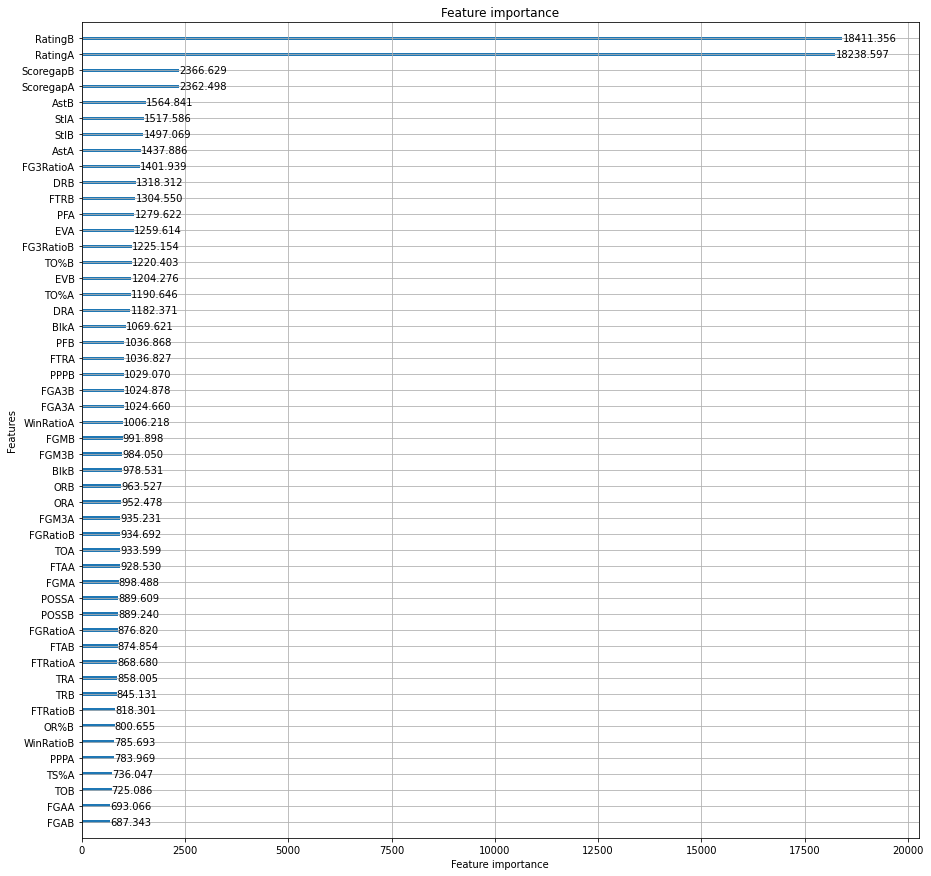

In [36]:
if TRAIN:
    fig,ax = plt.subplots(figsize=(15,15))
    lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
    plt.show();

### catboost

In [37]:
if CATBOOST:
    #  def train_catboost(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, cat_params, loss_func, calc_importances=False):
    seasons = tourney_results['Season'].unique()
    n = 13 # season 2016

    y_test_cat = []
    models_cat = []

    for season in seasons[n:]:
        print('valid_season{}'.format(season))
        train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
        valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

        train = train.sample(frac=1, random_state=SEED)
        x_train, y_train = train[features], train[target]
        x_val, y_val = valid[features], valid[target]

        if TRAIN:
            y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model_cat = \
                train_catboost(
                    x_train, y_train, x_val, y_val, test[features],
                    categorical_features = categorical_features,
                    fold_id = season,
                    cat_params = CAT_PARAMS,
                    loss_func = calc_loss
                )

            models_cat.append(model_cat)    
            #model.save_model(f'exp{EXP}_model_valid_season{season}.txt')

            y_test_cat.append(y_pred_test)

valid_season2016
valid_loss:  0.5741801805595407
get_best_iteration:  88
valid_season2017
valid_loss:  0.5351714280846518
get_best_iteration:  60
valid_season2018
valid_loss:  0.5687685708177351
get_best_iteration:  217
valid_season2019
valid_loss:  0.46657330237628214
get_best_iteration:  338
valid_season2021
valid_loss:  0.5869320677053761
get_best_iteration:  143


In [38]:
if CATBOOST:
    print(valid_loss)

0.5869320677053761


### xgboost

In [39]:
if XGBOOST:
    #  def train_catboost(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, cat_params, loss_func, calc_importances=False):
    seasons = tourney_results['Season'].unique()
    n = 13 # season 2016

    y_test_xgb = []
    models_xgb = []

    for season in seasons[n:]:
        print('valid_season{}'.format(season))
        train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
        valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

        train = train.sample(frac=1, random_state=SEED)
        x_train, y_train = train[features], train[target]
        x_val, y_val = valid[features], valid[target]

        if TRAIN:
            y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model_xgb = \
                train_xgboost(
                    x_train, y_train, x_val, y_val, test[features],
                    categorical_features = categorical_features,
                    fold_id = season,
                    xgb_params = XGB_PARAMS,
                    fit_params = XGB_FIT_PARAMS,
                    loss_func = calc_loss
                )

            models_xgb.append(model_xgb)    
            #model.save_model(f'exp{EXP}_model_valid_season{season}.txt')

            y_test_xgb.append(y_pred_test)

valid_season2016
[0]	train-logloss:0.69171	val-logloss:0.69237
[100]	train-logloss:0.57835	val-logloss:0.64040
[200]	train-logloss:0.49328	val-logloss:0.60372
[300]	train-logloss:0.42660	val-logloss:0.58118
[400]	train-logloss:0.37361	val-logloss:0.56832
[500]	train-logloss:0.33052	val-logloss:0.56441
[600]	train-logloss:0.29455	val-logloss:0.56147
[700]	train-logloss:0.26441	val-logloss:0.55869
[772]	train-logloss:0.24583	val-logloss:0.55910
valid_loss:  0.5592339594862354
valid_season2017
[0]	train-logloss:0.69172	val-logloss:0.69227
[100]	train-logloss:0.57831	val-logloss:0.62875
[200]	train-logloss:0.49355	val-logloss:0.59175
[300]	train-logloss:0.42693	val-logloss:0.56720
[400]	train-logloss:0.37390	val-logloss:0.55220
[500]	train-logloss:0.33104	val-logloss:0.54443
[600]	train-logloss:0.29511	val-logloss:0.54002
[700]	train-logloss:0.26484	val-logloss:0.53726
[800]	train-logloss:0.23988	val-logloss:0.53517
[857]	train-logloss:0.22756	val-logloss:0.53597
valid_loss:  0.53597175532

In [40]:
if XGBOOST:
    print(valid_loss)

0.5500140603293072


## Inference

In [41]:
# inference
y_test_sub =  np.mean(y_test,axis=0)

if ENSEMBLE == False:
    sub = pd.read_csv(SUB_PATH)
    sub["Pred"] = y_test_sub
    sub.to_csv(SAVE_TEST_SUB_PATH,index=False)
    sub.to_csv('submission.csv',index=False)
    print(sub.shape)    

#check
print(y_test_sub)
print(y_test_sub.shape)

[0.47037039 0.87306379 0.46498463 ... 0.489333   0.17950929 0.23716921]
(11390,)


In [42]:
if CATBOOST:
    # inference cat
    y_test_sub_cat =  np.mean(y_test_cat,axis=0)
    #check
    print(y_test_sub_cat)
    print(y_test_sub_cat.shape)

[0.57308007 0.87615132 0.55939252 ... 0.45295104 0.2393436  0.2704927 ]
(11390,)


In [43]:
if XGBOOST:
    # inference xgb
    y_test_sub_xgb =  np.mean(y_test_xgb, axis=0)
    #check
    print(y_test_sub_xgb)
    print(y_test_sub_xgb.shape)

[0.46671504 0.82753575 0.42014465 ... 0.39137572 0.23142631 0.28403232]
(11390,)


In [44]:
if ENSEMBLE:
    sub = pd.read_csv(SUB_PATH)
    sub['Pred'] = 0.5*y_test_sub +  0.5*y_test_sub_xgb #+ 0.2*y_test_sub_cat
    sub.to_csv(SAVE_TEST_SUB_PATH,index=False)
    sub.to_csv('submission.csv',index=False)
    print(sub.shape)

(11390, 2)


In [45]:
! ls

__notebook__.ipynb  catboost_info  exp001_submission.csv  submission.csv
